## Phising Dataset

To collect the dataset, we have deployed multiple agents and soluble agents within an infrastructure with
more than 3k entities, comprising laptops, workstations, and smartphone devices. <br> The methods to build
ground truth are as follows:

- Simulator: We launch different realistic phishing campaigns, aiming to expose user credentials or defeat access to a service.
- IDS: We deploy an IDS to collect various alerts associated with behavioral anomalies, such as cryptomining or peer-to-peer traffic.

For each user exposed to the behaviors stated in the summary table, different TW is computed, aggregating
user behavior within a fixed time interval. <br> This TW serves as the basis for generating various supervised
and unsupervised methods.

## Time window representation 

The time windows (TW) are a data representation based on aggregated logs from multimodal sources between two
timestamps. <br> In this study, logs from HTTP, DNS, SSL, and SMTP are taken into consideration, allowing the
construction of rich behavioral profiles. <br> The indicators described in the TE are a set of manually curated
interpretable features designed to describe device-level properties within the specified time frame.

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from modules.lib_IF import *
from modules.lib import *
from modules.optimizer import *
from xai_client import Client
import json


In [2]:
entity = "desktop" #desktop or smartphone
threat = "phishing_behaviour" 
path_dataset = f'data/Risky Behaviour Datasets/{threat}/min_windows_size_6/{entity}_features.pckl'
seed = 42
dataset = pd.read_pickle(path_dataset)

#### Load and split dataset based on the unique users

In [3]:
from sklearn.model_selection import train_test_split


unique_users = dataset.loc[dataset["label"] != -1, 'user_id'].unique()
# Split user IDs into train_test and validation sets
# We fix validation dataset to be always the same by fixing the random state, the rest changes
users_train_test, users_validation = train_test_split(unique_users, test_size=0.3, random_state=seed)

data_train_test = dataset[dataset['user_id'].isin(users_train_test)]
data_validation_labeled = dataset[dataset['user_id'].isin(users_validation)]


In [4]:
data_train_test = data_train_test.drop(columns=["timestamp", "user_id", "entity"])

In [5]:
data_validation_labeled = data_validation_labeled.drop(columns=["timestamp", "user_id", "entity"])

### Model creation and Training

In [6]:
import numpy as np
cat_columns = data_train_test.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = data_train_test.drop(columns='label').select_dtypes(exclude=['object']).columns.tolist()

In [10]:
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
    ])

hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ("Model", xgb.XGBClassifier())])

# optimizer = ModelOptimizer(ml_pipeline,param_grid=hyperparameters,optimization_algorithm='grid_search')
# opt = optimizer.optimize(data_train_test.drop(columns='label'),data_train_test.label)

In [7]:
# import itertools
# import time
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score,
#     confusion_matrix
# )
# param_keys = hyperparameters.keys()
# param_values = hyperparameters.values()
# combinations = list(itertools.product(*param_values))

# # Create an empty list to store results
# results = []
# all_test_results = []

# # Perform the grid search manually
# model_id = 0
# new_trained_models = {}
# for combination in combinations:
#     print(combination)
#     params = dict(zip(param_keys, combination))
    
#     ml_pipeline = Pipeline([("preprocessor", preprocessor),
#                         ("Model", xgb.XGBClassifier())])
#     # Set the parameters to the pipeline
#     ml_pipeline.set_params(**params)
    
#     # Record the start time
#     start_time = time.time()
    
#     # Fit the model
#     ml_pipeline.fit(data_train_test.drop(columns='label'), data_train_test.label)
#     new_trained_models[model_id] = ml_pipeline
#     # Record the end time
#     # end_time = time.time()
#     # runtime = end_time - start_time
    
#     # # Make predictions
#     # y_pred = ml_pipeline.predict(data_validation_labeled.drop(columns='label'))
    
#     # # Evaluate the model
#     # accuracy = accuracy_score(data_validation_labeled.label, y_pred)
#     # precision = precision_score(data_validation_labeled.label, y_pred, average='binary')
#     # recall = recall_score(data_validation_labeled.label, y_pred, average='binary')
#     # f1 = f1_score(data_validation_labeled.label, y_pred, average='binary')
#     # f1_macro = f1_score(data_validation_labeled.label, y_pred, average='macro')
    
#     # # Compute confusion matrix
#     # tn, fp, fn, tp = confusion_matrix(data_validation_labeled.label, y_pred).ravel()
    
#     # # Record the hyperparameters, performance, runtime, and model ID
#     # result = {
#     #     'max_depth': params['Model__max_depth'],
#     #     'min_child_weight': params['Model__min_child_weight'],
#     #     'learning_rate': params['Model__learning_rate'],
#     #     'n_estimators': params['Model__n_estimators'],
#     #     'scaler': type(params['preprocessor__num__scaler']).__name__,
#     #     'accuracy': accuracy,
#     #     'precision': precision,
#     #     'recall': recall,
#     #     'f1_score': f1,
#     #     'f1_macro': f1_macro,
#     #     'true_positives': tp,
#     #     'false_positives': fp,
#     #     'true_negatives': tn,
#     #     'false_negatives': fn,
#     #     'runtime': runtime,
#     #     'id': model_id
#     # }
#     # results.append(result)
    
#     # test_results_df = pd.DataFrame(data_validation_labeled.drop(columns='label'))
#     # test_results_df['label'] = data_validation_labeled.label
#     # test_results_df['prediction'] = y_pred
#     # test_results_df['id'] = model_id
    
#     # # Append the test results to the list
#     # all_test_results.append(test_results_df)
#     # Increment the model ID
#     model_id += 1
#     # if model_id==3:
#     #     break

# # Convert the results to a DataFrame
# # results_df = pd.DataFrame(results)

In [8]:
import joblib

opt = joblib.load('metadata/proxy_data_models/phising_fullgrid.pkl')

In [9]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T

In [10]:
# import joblib


# joblib.dump(opt, 'phising_fullgrid.pkl')

Accuracy Score is 0.647415329768271


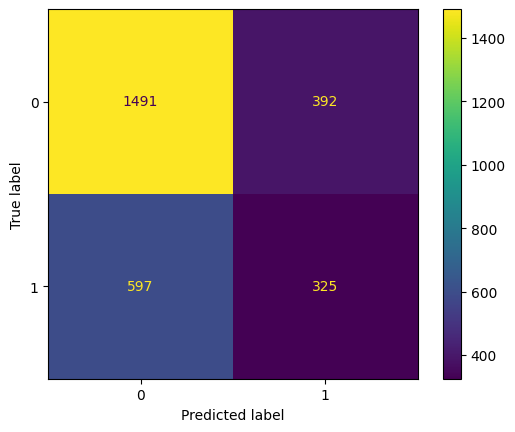

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

test = data_validation_labeled.drop(columns='label')
test_labels = data_validation_labeled.label
best_model = opt.best_estimator_
pred_y_test = best_model.predict(test)

print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(test_labels, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [12]:
cm = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

In [13]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1883
           1       0.45      0.35      0.40       922

    accuracy                           0.65      2805
   macro avg       0.58      0.57      0.57      2805
weighted avg       0.63      0.65      0.63      2805



In [14]:
classification_report = pd.DataFrame(classification_report(test_labels, pred_y_test,output_dict=True)).transpose()

## Proxy Model creation for PDP-ALE and Counterfactual Explanations

In [15]:
hyperparameters = {'Model__max_depth': (2, 4, 6, 10),
                                'Model__min_child_weight': (1, 3),
                                'Model__learning_rate': [0.001, 0.01, 0.1],
                                'Model__n_estimators': (25, 50, 75 , 100),
                                "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]}

In [16]:
    # proxy model for PDP-ALE
surrogate_model_accuracy = proxy_model(opt.param_grid,opt,'accuracy','XGBoostRegressor')

In [17]:
# missclassified = pd.concat([test, test_labels.rename('GroundTruth')], axis=1).reset_index(drop=True)
# missclassified['Predicted'] = pred_y_test
# missclassified['Label'] = (missclassified['GroundTruth'] != missclassified['Predicted']).astype(int)
# missclassified[missclassified['Label']==1]

In [18]:
# missclassified[missclassified['Label']==1].drop(columns='Label').to_csv('misclassified_instances.csv')

In [19]:
# missclassified[missclassified['Label']==1].drop(columns='Label')

In [20]:
missclassified_instances = pd.read_csv('Real_I2Cat_missclassified_instances.csv',index_col=0)
# misclassified_instance = missclassified.drop(columns=['GroundTruth','Label']).loc[5]
train = data_train_test.drop(columns='label')
train_labels = data_train_test.label
# #proxy_model and dataset for counterfactual explanations
# proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, misclassified_instance,hyperparameters)

In [21]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T


## Create gRPC Client

### Run `python xai_server.py` command on terminal in order to start server

### Compute PDP 1D Plots via gRPC

In [17]:
client = Client()
k = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='pdp',model='I2Cat_Phising_model',feature1='Model__n_estimators')

### Compute PDP 2D Plots via gRPC

In [19]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis,zAxis= client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='2dpdp',model='I2Cat_Phising_model',feature1='Model__min_child_weight',feature2='Model__max_depth')

### Compute ALE Plots via gRPC

In [20]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='hyperparameterExplanation',explanation_method='ale',model='I2Cat_Phising_model',feature1='Model__max_depth')

### Counterfactual Explanations via gRPC

In [21]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='hyperparameterExplanation',explanation_method='counterfactuals',model='I2Cat_Phising_model',model_id=1,query=str(missclassified_instances.reset_index(drop=True).drop(columns = ['label','prediction','id']).loc[806913].to_dict())))


## Model Explainability

### PDPlots and 2D PDPlots via gRPC

In [22]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis,zAxis = client.get_explanations(explanation_type='featureExplanation',explanation_method='pdp',
                                                  model = 'I2Cat_Phising_model',model_id=209, feature1='dns_interlog_time_q1')



## CounterfactualsExplanations via gRPC

In [23]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,table_contents = client.get_explanations(explanation_type='featureExplanation',explanation_method='counterfactuals',query=str(missclassified_instances.reset_index(drop=True).loc[806913].to_dict()),model='I2Cat_Phising_model',model_id = 10,target='label')

### ALE plots via gRPC

In [24]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='featureExplanation',explanation_method='ale',
                                                  model = 'I2Cat_Phising_model', model_id=21, feature1='dns_interlog_time_q1')

### Prototypes via gRPC

In [22]:
test = test.reset_index(drop=True)
test['predictions'] = opt.predict(test)

In [23]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='prototypes',query=str(test.loc[10].to_dict()),model='I2Cat_Phising_model',model_id = 10))

In [27]:
with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.GetExplanation(xai_service_pb2.ExplanationsRequest(explanation_type='featureExplanation',explanation_method='2D_PDPlots',model = 'I2Cat_Phising_model',model_id=256, feature1='dns_interlog_time_q1',feature2='dns_interlog_time_q2'))

In [4]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.Initialization(xai_service_pb2.InitializationRequest(model_name = 'I2Cat_Phising_model'))

In [22]:
import grpc
import xai_service_pb2
import xai_service_pb2_grpc

with grpc.insecure_channel('localhost:50051') as channel:
    stub = xai_service_pb2_grpc.ExplanationsStub(channel)
    k = stub.ModelAnalysisTask(xai_service_pb2.ModelAnalysisTaskRequest(model_name = 'I2Cat_Phising_model',model_id=258))

In [34]:
pd.read_csv('Real_I2Cat_metrics.csv',index_col=0)

,max_depth,min_child_weight,learning_rate,n_estimators,scaler,accuracy,precision,recall,f1_score,f1_macro,true_positives,false_positives,true_negatives,false_negatives,runtime,id
0,2,1,0.001,25,StandardScaler,0.671301,0.000000,0.000000,0.000000,0.401664,0,0,1883,922,0.288919,0
1,2,1,0.001,25,MinMaxScaler,0.671301,0.000000,0.000000,0.000000,0.401664,0,0,1883,922,0.210936,1
2,2,1,0.001,25,RobustScaler,0.671301,0.000000,0.000000,0.000000,0.401664,0,0,1883,922,0.316979,2
3,2,1,0.001,50,StandardScaler,0.671301,0.000000,0.000000,0.000000,0.401664,0,0,1883,922,0.302653,3
4,2,1,0.001,50,MinMaxScaler,0.671301,0.000000,0.000000,0.000000,0.401664,0,0,1883,922,0.289628,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,10,3,0.100,75,MinMaxScaler,0.652406,0.463649,0.366594,0.409449,0.581587,338,391,1492,584,1.172474,283
284,10,3,0.100,75,RobustScaler,0.652406,0.463649,0.366594,0.409449,0.581587,338,391,1492,584,1.210568,284
285,10,3,0.100,100,StandardScaler,0.646702,0.453691,0.366594,0.405519,0.577094,338,407,1476,584,1.446060,285
286,10,3,0.100,100,MinMaxScaler,0.646702,0.453691,0.366594,0.405519,0.577094,338,407,1476,584,1.432751,286
